![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Numerical Methods in Geotechnical Engineering**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics


# Softening behavior and its consequences

## Example problem

We consider a minimal system to describe buckling.

![minimal_buckling_model.png](https://raw.githubusercontent.com/nagelt/Numerical_Methods_Introduction/master/Images/minimal_buckling_model.png)

Let's use our intuition for two limit cases. For a tiny mass and a stiff spring we expect the bar to stand upright, whereas for a huge mass and a soft spring, we expect it hanging down (either to the left or right). 
From these limits we can conclude that a stability loss of the upright position occurs. This stability loss, in terms of mechanics, corresponds to passing a state of zero stiffness. Thinking scalarly of F=ku we anticipate that solving for u=F/k fails when $k=0$. Indeed applying Newton's method the iterations do not converge (compare to exercise 04a starting Newton iterations on a point with a horizonal tangent).
However non-converging iterations are neither a reliable nor an efficient indicator. So we go for an advanced method. In addition we obtain a glance into the exciting world of nonlinear systems.
It goes without saying that you won't find nonlinear effects in a _linear world_, so make sure to enable nonlinear geometry in your FEM-code, if you want to analyse a structure for buckling.

In [1]:
import numpy as np #numerical methods
from scipy.optimize import root # Newton's method outsourced
import matplotlib.pyplot as plt # plotting

from ipywidgets import widgets
from ipywidgets import interact

#Some plot settings
import plot_functions.plot_settings
%run plot_functions/Newton_arclength_plots.ipynb

## Principle of Minimum Potential Energy

Since nature is lazy, all stable equilibria minimize potential energy (statics, conservative system). Note that maxima describe instable equilibria.
For our system we have the potential energy of the rotational spring and of a mass in a gravitational field
\begin{align}
\Pi_\mathrm{spring} &= \frac{1}{2}c(\varphi-\varphi_0)^2, \\
\Pi_\mathrm{grav} &= mgl\sin \varphi.
\end{align}
The necessary condition for an equilibrium
\begin{equation}
\frac{\partial \Pi}{\partial \varphi}=0,
\end{equation}
corresponds to an equilibrium of forces.
From the second derivative we may identify the equilibrium as minimum $\left(\frac{\partial^2 \Pi}{\partial \varphi^2}>0\right)$ or maximum of potential energy $\left(\frac{\partial^2 \Pi}{\partial \varphi^2}<0\right)$, or we have to check higher derivatives $\left(\frac{\partial^2 \Pi}{\partial \varphi^2}=0\right)$.


With the spring relaxed at standing upright ($\varphi_0=\pi/2$) we define functions for potential energy and its derivatives. Note that we make potential energy nondimensional, thus leaving only one parameter
\begin{equation}
\frac{\Pi}{\Pi_\mathrm{ref}} = \frac{1}{2}(\varphi-\varphi_0)^2 + \mu \sin \varphi,
\end{equation}
with $\mu=\frac{mgl}{c}$.

In [2]:
phi0 = 0.5*np.pi   

In [3]:
Epot = lambda phi, mu: 0.5*(phi-phi0)**2 + mu*np.sin(phi) # energy
dEpot_dphi = lambda phi, mu: phi - phi0 + mu*np.cos(phi)  # force
d2Epot_dphi2 = lambda phi, mu: 1 - mu*np.sin(phi)         # stability
d2Epot_dphi_dmu = lambda phi, mu: np.cos(phi)             # for tangent

In [4]:
plot_interactive_energy_landscape()

interactive(children=(FloatSlider(value=0.5, description='$\\mu$', max=2.0), Output()), _dom_classes=('widget-…

Observe how the energy landscape changes from single-well ($\mu<1$) to a double well ($\mu>1$). Basically this figure already explains everything, for a small load there is one equilibrium (upright) and for a huge load the upright position gets instable (maximum) and there occur two stable equilibria (minima), one to the left and the other to the right.

## Solution with the pseudo arc-length method

The equation (equilibrium) to solve is transcendental
\begin{equation}
f(\varphi) = \varphi-\varphi_0 + \mu \cos \varphi = 0,
\end{equation}
so we resort to numerical methods.
Newtons method, however, runs into trouble for $\mu \to 1$, because then the tangent 
\begin{equation}
\frac{\mathrm{d}f}{\mathrm{d}\varphi} = 1 - \mu \sin \varphi
\end{equation}
at the equilibrium ($\varphi=\varphi_0=\frac{\pi}{2}$) approaches zero.


Now it is time for the clever move, instead of solving for $\varphi$ with the fixed parameter $\mu$, we think of a solution curve in $\varphi$-$\mu$ space. Starting from a known point of this curve, e.g. the trivial unloaded case $\mu=0$, we progress pointwise by imposing a fixed distance (called pseudo arc-length because coordinate $\varphi$ and parameter $\mu$ do not measure a spatial distance) from one point to another (index _p_ denotes previous point).

In [5]:
distance_squared = lambda phi,mu, phi_p,mu_p: 0.1*(phi-phi_p)**2 + (mu-mu_p)**2   # pseudo arc-length squared
d_distance_squared_dphi = lambda phi,mu, phi_p,mu_p: 2*0.1*(phi-phi_p)  # for tangent
d_distance_squared_dmu = lambda phi,mu, phi_p,mu_p: 2*(mu-mu_p)   # for tangent

Note that the weigthing for the arc-length required some divine inspiration, we are not teaching here.

The extended system (two equations for two unknowns), we have to solve, reads

In [6]:
def sys(z, zp, ds):
    phi = z[0]
    mu = z[1]
    phi_p = zp[0]
    mu_p = zp[1]
    
    r0 = dEpot_dphi(phi, mu)   # equilibrium
    r1 = distance_squared(phi, mu, phi_p, mu_p) - ds**2 # distance constraint
    
    res = np.array([r0, r1])
    return res

And its tangent reads 

In [7]:
def dsys(z, zp, ds):
    phi = z[0]
    mu = z[1]
    phi_p = zp[0]
    mu_p = zp[1]
    
    J00 = d2Epot_dphi2(phi, mu)
    J01 = d2Epot_dphi_dmu(phi, mu)
    J10 = d_distance_squared_dphi(phi, mu, phi_p, mu_p)
    J11 = d_distance_squared_dmu(phi, mu, phi_p, mu_p)
    
    J = np.matrix([[J00, J01], [J10, J11]])
    return J

Starting from the unloaded initial state we increase the load (direction guided by start value of the iterations). In addition we observe the stability of the calculated states (from nonlinear systems theory it is known that a change of stability typically indicates branching of solutions).

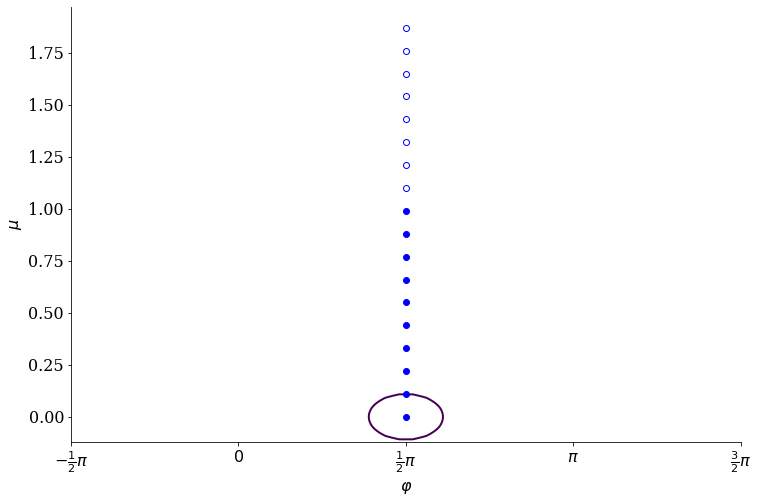

In [8]:
ds = 0.11   # arc-length between two successive points (resolution of solution points)

z0 = np.array([0.5*np.pi, 0]) # unloaded state
zp = z0
dz= np.array([0, ds])  # assumed step to the next point (determines direction)

stable_phi = []
stable_mu =[]
nonstable_phi = []
nonstable_mu = []
stable_prev = True   # we known by intution that the initial state is stable

for k in range(17):
    ZS = root(sys, zp+dz, args=(zp,ds), jac=dsys, method='hybr') 
    zs =ZS.x   # extract value from solution structure
    stable = d2Epot_dphi2(zs[0], zs[1]) > 0
    if stable:
        stable_phi.append( zs[0] )
        stable_mu.append( zs[1] )
    else:        
        nonstable_phi.append( zs[0] )
        nonstable_mu.append( zs[1] )
        
    if not stable==stable_prev:
        branchpoint = 0.5*(zp+zs) # stability change appeared somewhere in between
    
    # move on
    dz = zs - zp 
    zp = zs
    stable_prev = stable
  
# plot points of mu-phi curve
plt.plot(stable_phi, stable_mu, 'bo')
plt.plot(nonstable_phi, nonstable_mu, 'bo', fillstyle='none')
plt.xlabel('$\\varphi$')
plt.ylabel('$\mu$')
tick_pos= [ -np.pi/2, 0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['$-\\frac{1}{2}\pi$', '$0$', '$\\frac{1}{2}\pi$', '$\pi$', '$\\frac{3}{2}\pi$']
plt.xticks(tick_pos, labels)

# plot distance constraint for initial point
plt.plot(z0[0], z0[1], 'bo')   # initial point
phi_range = np.linspace(-np.pi, np.pi)
mu_range =  np.linspace(-1.1*ds, 1.1*ds)
PHI, MU = np.meshgrid(phi_range, mu_range)
ZERO = np.zeros(PHI.shape)
DS = np.sqrt(distance_squared(PHI, MU, ZERO, ZERO)) # refer to initial point (delta_phi=delta_mu=0)
plt.contour(PHI+phi0, MU, DS, [ds])  # distance constraint

plt.show()

A filled circle denotes a stable equilibrium and an empty circle an instable equilibrium.

The ellipse around the initial point shows where the next point, in this case the first point, has to be located, as dictated by the distance constraint. We will find intersections of the constraint-ellipse with the $\phi$-$\mu$-curve for all directions, even when the $\phi$-$\mu$-curve goes horizontal and the formulation for fixed $\mu$ fails. For a quantitative analysis and to receive some inspiration for setting the pseudo arc-length metric it is advisable to calculate the determinant of the Jacobian (in function ``dsys``).

We note that the upright position is an equilibrium and at $\mu=1$ it becomes unstable.
Now we take a closer look at this point (stability loss) and try to follow the stable equilibrium branching off into the buckled state. Therefore we start the iterations from a state without load increase but rotated out of the vertical position ($\varphi\ne\pi/2$).

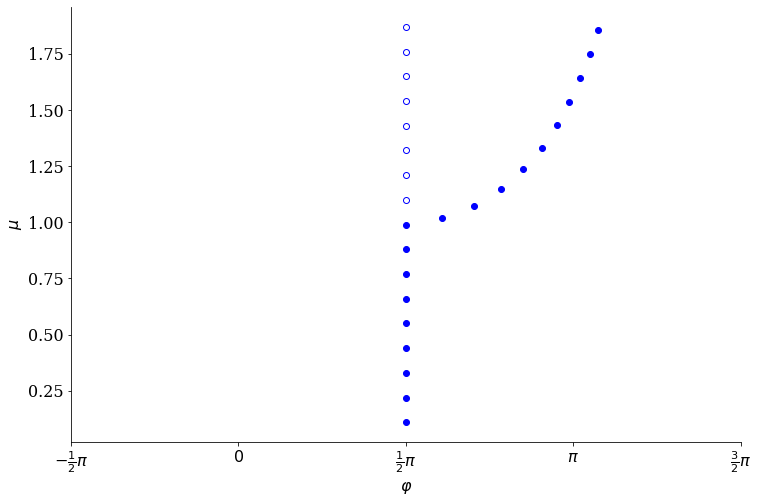

In [9]:
zp = branchpoint
dz = np.array([0.5, 0.0])   # guide direction to find other branch
for k in range(10):
    ZS = root(sys, zp+dz, args=(zp,ds), jac=dsys, method='hybr') 
    zs =ZS.x
    if d2Epot_dphi2(zs[0], zs[1]) > 0:
        stable_phi.append( zs[0] )
        stable_mu.append( zs[1] )
    else:
        nonstable_phi.append( zs[0] )
        nonstable_mu.append( zs[1] )
    dz = zs -zp
    zp = zs

plt.plot(stable_phi, stable_mu, 'bo')
plt.plot(nonstable_phi, nonstable_mu, 'bo', fillstyle='none')
plt.xlabel('$\\varphi$')
plt.ylabel('$\mu$')
tick_pos= [ -np.pi/2, 0, np.pi/2, np.pi, 3*np.pi/2]
labels = ['$-\\frac{1}{2}\pi$', '$0$', '$\\frac{1}{2}\pi$', '$\pi$', '$\\frac{3}{2}\pi$']
plt.xticks(tick_pos, labels)
plt.show()

In accordance with our initial intuitive expectation we recognize the buckled state branching off when the critical load is exceeded.
By symmetry there is also a mirrored branch (buckling to the other side). It is not shown here, but if you imagine it, then you may understand why this kind of bifurcation is called _pitchfork_.

There is much more to discover. In terms of physics it may be interesting to study the influence of an imperfection ($\varphi_0\ne \pi/2$), whereas in terms of numerics it is desireable to automate the pseudo arc-length metric, to predict branched curves and to make sure all branches have been found. For further reading we recommend the textbooks _Nonlinear Oscillations, Dynamical Systems, and Bifurcations of Vector Fields_ by J. Guckenheimer and P. Holmes and _Elements of Applied Bifurcation Theory_ by Y. Kuznetsov.